In [1]:
import numpy as np
import pandas as pd
import os
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import math
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [2]:
def calculateVolatility(df):
    vol=[]
    numTradingDays = 252
    numTicksPerDay = 26
    logprice=np.log(df['Price'])
    vol.append(np.nan)
    for i in range(df.shape[0]-1):
        logdif=logprice[i+1]-logprice[i]
        difsq=logdif**2
        vol.append(np.sqrt(numTradingDays*numTicksPerDay*difsq))
    df['Volatility'] = vol

In [3]:
def getAdfuller(vol):
    result = adfuller(vol.dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

In [4]:
def acfPlot(vol):
    fig, axes = plt.subplots(1, 2, sharex=True)
    axes[0].plot(vol); axes[0].set_title('Series')
    plot_acf(vol.dropna(), ax=axes[1])
    axes[0].set(xlim=(0,30))
    plt.show()

In [5]:
def pacfPlot(vol):
    plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
    fig, axes = plt.subplots(1, 2, sharex=True)
    axes[0].plot(vol.dropna())
    axes[0].set_title('No Differencing')
    axes[1].set(ylim=(0,1))
    axes[0].set(xlim=(0,30))
    plot_pacf(vol.dropna(), ax=axes[1])
    plt.show()

In [6]:
def earningsVariable(df, name):
    earns = pd.read_csv("EarningsRelease.csv")
    company_date=earns.loc[np.where(earns['Company']==name)]
    today=np.zeros(df['Date'].shape[0])
    yesterday=np.zeros(df['Date'].shape[0])
    tomorrow=np.zeros(df['Date'].shape[0])
    date_col=df['Date']
    for i in range(date_col.shape[0]):
        if(company_date['Date'].item() in date_col[i]):
            today[i]=1
            yesterday[i-96]=1
            if(name != 'Rivian' and name != 'Oracle'):
                tomorrow[i+96]=1
    df["Earnings Release"]=today
    df["Day Before Earnings Release"]=yesterday
    df["Day After Earnings Release"]=tomorrow
    return df

In [7]:
def calculateOvernightFeatures(df):
    df['DateTime'] = pd.to_datetime(df['Date'], format='%m/%d/%y %H:%M')
    df['Date'] = df['DateTime'].dt.date
    dates = np.unique(df['Date'])

    overnight_tweet_count_dict = {}
    overnight_pos_sentiment_dict = {}
    overnight_neg_sentiment_dict = {}

    # this is hard coded, assumed same start date for all data
    start_date = datetime(2021, 12,26, 16, 0)
    end_date = datetime(2021,12,27,9,15)

    # loops through unique dates 
    for idx, date in enumerate(dates):
        # recalculate start/end dates
        if idx != 0:
            start_date = datetime(dates[idx-1].year, dates[idx-1].month, dates[idx-1].day, 16, 0)
            end_date = datetime(dates[idx].year, dates[idx].month, dates[idx].day, 9, 15)

        # finds rows in date range
        in_range = df[(df['DateTime'] <= end_date) & (df['DateTime'] >= start_date)]
        
        # get the Twitter by summing columns then add to dictionary
        tweet_count = in_range['Twitter Publication Count - Realtime (L1)'].sum()
        pos_sentiment_count = in_range['Twitter Positive Sentiment Count - Realtime'].sum()
        neg_sentiment_count = in_range['Twitter Negative Sentiment Count - Realtime'].sum()

        overnight_tweet_count_dict[date] = tweet_count
        overnight_pos_sentiment_dict[date] = pos_sentiment_count
        overnight_neg_sentiment_dict[date] = neg_sentiment_count


    # indexes dictionary by each Date in the data frame to create a list of overnight tweet counts
    overnight_tweet_count_list = [overnight_tweet_count_dict[df.iloc[i,0]] for i in range(len(df))]
    overnight_pos_sentiment_list = [overnight_pos_sentiment_dict[df.iloc[i,0]] for i in range(len(df))]
    overnight_neg_sentiment_list = [overnight_neg_sentiment_dict[df.iloc[i,0]] for i in range(len(df))]

    df['overnight_tweet_count'] = overnight_tweet_count_list
    df['overnight_positive_sentiment'] = overnight_pos_sentiment_list
    df['overnight_negative_sentiment'] = overnight_neg_sentiment_list

    df['Date'] = df['DateTime']
    df.drop('DateTime', axis =1, inplace=True)
    
    return df

In [8]:
def dayOfWeekVar(df):
    date_col=df['Date']
    days=np.zeros(df['Date'].shape[0])
    for i in range(date_col.shape[0]):
        days[i]=date_col[i].dayofweek
    monday=np.where(days==0, 1, 0)
    tuesday=np.where(days==1, 1, 0)
    wednesday=np.where(days==2, 1, 0)
    thursday=np.where(days==3, 1, 0)
    friday=np.where(days==4, 1, 0)
    df['Monday']=monday
    df['Tuesday']=tuesday
    df['Wednesday']=wednesday
    df['Thursday']=thursday
    df['Friday']=friday
    return df

In [9]:
def amOrPmVar(df):
    dates = df['Date']
    
    is_morning = [1 if date.hour < 12 else 0 for date in dates]
    df['before_noon'] = is_morning
    return df

In [10]:
def arimaModel(vol, p, d, q):
    model = ARIMA(vol.dropna(), order=(p,d,q))
    model_fit = model.fit()
    #print(model_fit.summary())
    return model_fit

def sarimaxModel(vol, exo, p, d, q):
    model = SARIMAX(vol.dropna(), exog = exo, order=(p,d,q))
    model_fit = model.fit(disp=False)
    return model,model_fit

In [11]:
def flipOrder(df):
    df=df.reindex(index=df.index[::-1])
    df=df.reset_index()
    del df['index']
    return df

def setDateToDate(df):
    df['Date'] = pd.to_datetime(df['Date'])
    return df

def fillTwitterNas(df):
    df['Twitter Publication Count - Realtime (L1)'].fillna(0, inplace=True)
    df['Twitter Positive Sentiment Count - Realtime'].fillna(0, inplace=True)
    df['Twitter Negative Sentiment Count - Realtime'].fillna(0, inplace=True)
    
def setDateIndex(df):
    df = setDateToDate(df)
    df.set_index('Date', drop=True, inplace=True)
    
def shiftTwitter(df):
    df['Twitter Publication Count - Realtime (L1)'] = df['Twitter Publication Count - Realtime (L1)'].shift(periods=-1)
    df['Twitter Positive Sentiment Count - Realtime'] = df['Twitter Positive Sentiment Count - Realtime'].shift(periods=-1)
    df['Twitter Negative Sentiment Count - Realtime'] = df['Twitter Negative Sentiment Count - Realtime'].shift(periods=-1)
    return df

def scaleTwitterData(df):
    scaler = StandardScaler()
    df['Twitter Publication Count - Realtime (L1)'] = scaler.fit_transform(df['Twitter Publication Count - Realtime (L1)'].to_numpy().reshape(-1,1))
    df['Twitter Positive Sentiment Count - Realtime'] = scaler.fit_transform(df['Twitter Positive Sentiment Count - Realtime'].to_numpy().reshape(-1,1))
    df['Twitter Negative Sentiment Count - Realtime'] = scaler.fit_transform(df['Twitter Negative Sentiment Count - Realtime'].to_numpy().reshape(-1,1))
    df['overnight_tweet_count'] = scaler.fit_transform(df['overnight_tweet_count'].to_numpy().reshape(-1,1))
    df['overnight_positive_sentiment'] = scaler.fit_transform(df['overnight_positive_sentiment'].to_numpy().reshape(-1,1))
    df['overnight_negative_sentiment'] = scaler.fit_transform(df['overnight_negative_sentiment'].to_numpy().reshape(-1,1))
    return df
    

In [12]:
def outOfSampleError(test_vol, test_exog, model, p, q):
    parameters = model.params.to_dict()
    model_new = SARIMAX(test_vol.dropna(), exog = test_exog, order=(p,0,q))
    with model_new.fix_params(parameters):
        model_fit = model_new.fit(disp=False)
        
    return calculateError(test_vol, model_fit)

def calculateError(true_vol, model):
    preds = model.predict()
    mse = mean_squared_error(preds, true_vol)
    return mse

In [13]:
def bestParams(vol, maxP, maxQ):
    bestp=0
    bestq=0
    bestd=0
    bestaic=1000000000
    d=0
    for p in range(maxP):
        for q in range(maxQ):
            fit=arimaModel(vol, p+1, d ,q+1)
            aic=fit.aic
            if(aic<bestaic):
                bestp=p+1
                bestq=q+1
                bestd=d
                bestaic=aic
    return bestp, bestq

def bestParamsSarimax(vol, exo, maxP, maxQ):
    bestp=0
    bestq=0
    bestd=0
    bestaic=1000000000
    d=0
    for p in range(maxP):
        for q in range(maxQ):
            _, fit=sarimaxModel(vol, exo, p+1, d ,q+1)
            aic=fit.aic
            if(aic<bestaic):
                bestp=p+1
                bestq=q+1
                bestd=d
                bestaic=aic
    return bestp, bestq

In [14]:
def crossVal(vol, exo, maxP, maxQ): 
    best_p = 0
    best_q = 0
    best_mse = 0
    tscv = TimeSeriesSplit()
    
    for p in range(maxP):
        for q in range(maxQ):
            
            mseList = []
            
            for train_index, test_index in tscv.split(exo):
                train_vol = vol.loc[train_index]
                train_exo = exo.loc[train_index]
                test_vol = vol.loc[test_index]
                test_exo = exo.loc[test_index]
                
                _, fit = sarimaxModel(train_vol, train_exo, p+1, 0 ,q+1)
                
                mse = outOfSampleError(test_vol, test_exo, fit, p+1, q+1)
                mseList.append(mse)
                
            
            avg_mse = np.mean(mseList)
            if avg_mse < best_mse or best_mse == 0:
                best_p = p+1
                best_q = q+1
                best_mse = avg_mse
                
    return best_p, best_q

In [15]:
def fullModel(df, maxP, maxQ):
    df=flipOrder(df)
    calculateVolatility(df)
    volatility=df['Volatility']
    getAdfuller(volatility)
    acfPlot(volatility)
    pacfPlot(volatility)
    p, q = bestParams(volatility, maxP, maxQ)
    model = arimaModel(volatility,p,0, q)
    return model

def fullSarimaxModel(df, maxP, maxQ, stockName):
    df=flipOrder(df)
    calculateVolatility(df)
    volatility=df['Volatility']
    getAdfuller(volatility)
    acfPlot(volatility)
    pacfPlot(volatility)
    df = earningsVariable(df, stockName)
    temp = setDateToDate(df)
    df = dayOfWeekVar(df)
    df = calculateOvernightFeatures(df)
    fillTwitterNas(df)
    df = scaleTwitterData(df)
    df = shiftTwitter(df)
    
    df.dropna(subset=['Volatility'], inplace=True)
    df = df.reset_index()
    df_exogenous = df.drop(['index','Date', 'Price', 'Volatility'], axis=1)
  
    volatility=df['Volatility']
    
    p, q = crossVal(volatility, df_exogenous, maxP, maxQ)
    model, model_fit = sarimaxModel(volatility, df_exogenous, p,0, q)
    return model, model_fit

def getSarimaxDf(df, stockName):
    df=flipOrder(df)
    calculateVolatility(df)
    volatility=df['Volatility']
    df = earningsVariable(df, stockName)
    temp = setDateToDate(df)
    df = dayOfWeekVar(df)
    df = calculateOvernightFeatures(df)
    fillTwitterNas(df)
    df = scaleTwitterData(df)
    df = shiftTwitter(df)
    
    df.dropna(subset=['Volatility'], inplace=True)
    df = df.reset_index()
    df_exogenous = df.drop(['index','Date', 'Price', 'Volatility'], axis=1)
  
    volatility=df['Volatility']
    
    return df_exogenous,volatility
    

ADF Statistic: -4.056073
p-value: 0.001144


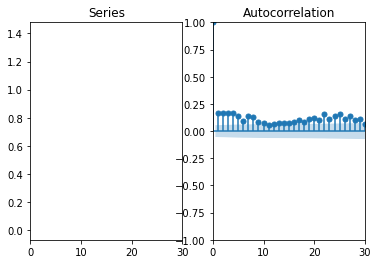

/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


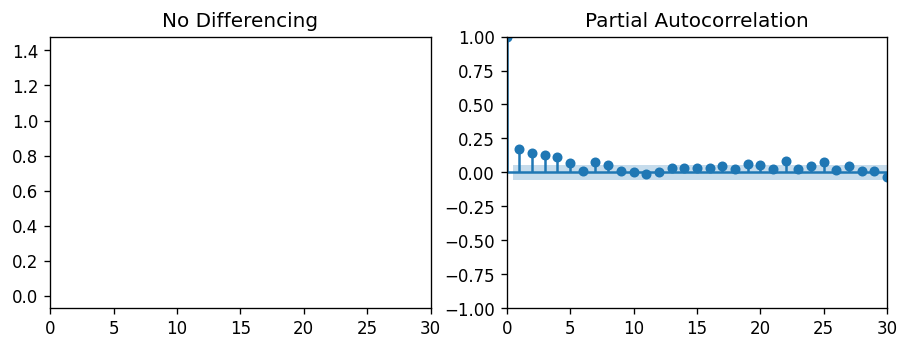

/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/odric

/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/odricketts/Documents/SP20

/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressiv

/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressiv

/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/odric

/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/odric

/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/odric

/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/odricketts/Documents/SP20

/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressiv

/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressiv

/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressiv

/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/odric

/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressiv

/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/odricketts/Documents/SP2022/ese527/venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/odric

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Volatility   No. Observations:                 1300
Model:               SARIMAX(2, 0, 2)   Log Likelihood                 457.535
Date:                Tue, 03 May 2022   AIC                           -877.071
Time:                        17:40:09   BIC                           -778.838
Sample:                             0   HQIC                          -840.214
                               - 1300                                         
Covariance Type:                  opg                                         
===============================================================================================================
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Twitter Publication Count - Realtime (L1)      -0.0222      0.012     -1.780      0.075      -0.047       0.002
Twitter Positive Sentiment Count - Realtime     0.0227      0.012      1.882      0.060      -0.001       0.046
Twitter Negative Sentiment Count - Realtime    -0.0143      0.005     -2.844      0.004      -0.024      -0.004
Earnings Release                             9.355e-17        nan        nan        nan         nan         nan
Day Before Earnings Release                 -1.009e-17        nan        nan        nan         nan         nan
Day After Earnings Release                   -8.34e-17    1.5e-11  -5.56e-06      1.000   -2.94e-11    2.94e-11
Monday                                          0.2002      0.027      7.371      0.000       0.147       0.253
Tuesday                                         0.1993      0.027      7.386      0.000       0.146       0.252
Wednesday                                       0.1785      0.026      6.738      0.000       0.127       0.230
Thursday                                        0.1690      0.026      6.550      0.000       0.118       0.220
Friday                                          0.1813      0.026      6.855      0.000       0.129       0.233
overnight_tweet_count                           0.0858      0.041      2.071      0.038       0.005       0.167
overnight_positive_sentiment                   -0.0599      0.037     -1.630      0.103      -0.132       0.012
overnight_negative_sentiment                    0.0164      0.011      1.484      0.138      -0.005       0.038
ar.L1                                           0.5233      1.888      0.277      0.782      -3.178       4.225
ar.L2                                           0.4524      1.857      0.244      0.807      -3.186       4.091
ma.L1                                          -0.4737      1.881     -0.252      0.801      -4.161       3.213
ma.L2                                          -0.4437      1.772     -0.250      0.802      -3.916       3.029
sigma2                                          0.0290      0.001     32.863      0.000       0.027       0.031
===================================================================================
Ljung-Box (L1) (Q):                   0.60   Jarque-Bera (JB):              1496.57
Prob(Q):                              0.44   Prob(JB):                         0.00
Heteroskedasticity (H):               2.02   Skew:                             1.57
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.61e+21. Standard errors may be unstable.
"""

In [16]:
google = pd.read_csv('trainingData/google.csv')
model, model_fit = fullSarimaxModel(google, 5, 5, 'Alphabet')
model_fit.summary()

In [158]:
google = pd.read_csv('trainingData/google.csv')
df_exog, vol = getSarimaxDf(google, 'Alphabet')
vol

0       0.177155
1       0.023847
2       0.276840
3       0.026494
4       0.002494
          ...   
1295    0.088734
1296    0.057314
1297    0.136746
1298    0.026895
1299    0.002744
Name: Volatility, Length: 1300, dtype: float64